Test bed for the proper-python module

In [1]:
# Add local scripts to module search path
import sys
import os
from pathlib import Path
path = str(Path().resolve())
sys.path.append((path[0:len(path)-len("notebooks/TinyTol")]) + "toliman-proper")
from astropy.io import fits as pyfits

In [2]:
from proper_cache import clear_all_cached

if False:
    clear_all_cached()
    

/Users/louis/.local/lib/python3.6/site-packages/pyfits-3.5-py3.6-macosx-10.7-x86_64.egg/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [3]:
from proper_tools import form_detector_image
from spirals import binarized_ringed_flipped


prescription = 'prescription_rc_quad'

beam_ratio = 0.4
gridsize = 2048

def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5 # Has units of nm
    return binarized_ringed_flipped(r, phi, phase)


toliman_settings_1 = {
                    'diam': 0.3,                       # telescope diameter in meters
                    'm1_fl': 571.7300 / 1000.,         # primary focal length (m)
                    'm1_m2_sep': 549.240/1000.,        # primary to secondary separation (m)
                    'm2_fl': -23.3800/1000.,           # secondary focal length (m)
                    'bfl': 590.000 / 1000.,            # nominal distance from secondary to focus (m)
                    'm2_rad': 5.9 / 1000.,             # Secondary half-diameter (m)
                    'm2_strut_width': 0.01,            # Width of struts supporting M2 (m)
                    'm2_supports': 5,                  # Number of support structs (assumed equally spaced)
                    'beam_ratio': beam_ratio,          # Initial beam width/grid width
                    'tilt_x': -0.00,                   # Tilt angle along x (arc seconds)
                    'tilt_y': -0.00,                   # Tilt angle along y (arc seconds)
                    'opd_func': binarized_ringed_650,  # Phase pupil function
                    'm1_hole_rad':0.025,               # Radius of hole in primary (m)
                    'use_caching':True                 # Use cached files if available?
                    }          


toliman_settings_2 = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 5.00,
                    'tilt_y': 5.00,
                    'opd_func': binarized_ringed_650,
                    'm1_hole_rad':0.025,
                    'use_caching':True
                    }



detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm,vmin=None,vmax=None,title=None):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    im = plt.imshow(imarray[int(c-w):int(c+w),int(c-w):int(c+w)],cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]], norm=LogNorm(),vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

In [4]:
viewport = 1. # mm

In [5]:
# Micrometer wavelength values

#wl_vals = [.6]
#wl_weights = [.1]

wl_vals = np.linspace(0.5,0.6,3)
wl_weights = [1.]

#wl_vals = [5.999989e-01, 6.026560e-01, 6.068356e-01, 6.119202e-01, 6.173624e-01, 6.226281e-01, 6.270944e-01, 6.300010e-01 ]
#wl_weights = [5.3770e-02, 1.1224e-01, 1.5056e-01, 1.7034e-01, 1.7342e-01, 1.5861e-01, 1.2166e-01, 5.9360e-02 ]

w2_vals = np.linspace(0.6,0.7,3)
w2_weights = [.5]

In [33]:
# First source, on axis
source_a = {
            'wavelengths': wl_vals,
            'weights': wl_weights,
            'settings': toliman_settings_1
            }

# Second source, off axis
source_b = {
            'wavelengths': w2_vals,
            'weights': w2_weights,
            'settings': toliman_settings_2
            }

sources = [source_b]#[source_a, source_b]

In [34]:
%%time
image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)

CPU times: user 1.56 s, sys: 642 ms, total: 2.21 s
Wall time: 7.58 s


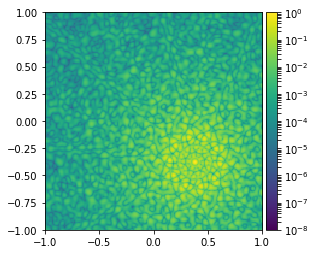

In [35]:
%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, viewport, vmin=1e-8)
plt.show()

## Now use spectra generated from pysynphot

In [5]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy.table import Table 
from cycler import cycler

%pylab inline --no-import-all

matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(6.0,4.0)  #(12.0,9.0)    
matplotlib.rcParams['font.size']=10              #18 
matplotlib.rcParams['savefig.dpi']= 72             #300
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'

# mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

#colours = mpl.rcParams['axes.color_cycle'] - Generates a keyerror in matplotlib

import pysynphot as S

import specutils
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d

Populating the interactive namespace from numpy and matplotlib


/Users/louis/anaconda3/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /Users/louis/special_project/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [6]:
# Sets our collecting area
r = 1 # cm
tinytol_area = np.pi*r**2
S.refs.setref(area=tinytol_area)  # cm2

In [7]:
# Icat(Teff, Z, log g)
# Default units are photlam and angstrom
acenA = S.Icat('phoenix',5790,0.2,4.30)
nwavels = 6000
wavels = np.linspace(3000,9000,nwavels)
specA = acenA.sample(wavels)

In [8]:
acenB = S.Icat('phoenix',5260,0.23,4.37)
nwavels = 6000
wavels = np.linspace(3000,9000,nwavels)
specB = acenB.sample(wavels)

Text(0.5,1.01,'Test Generating Spectra - $\\alpha$ Cen')

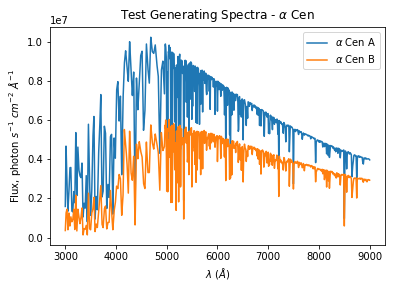

In [9]:
plt.plot(wavels,specA,label=r'$\alpha$ Cen A')
plt.plot(wavels,specB,label=r'$\alpha$ Cen B')
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Flux, photon $s^{-1}$ $cm^{-2}$ $\AA^{-1}$')
plt.legend()
plt.title(r'Test Generating Spectra - $\alpha$ Cen',y=1.01)

In [10]:
# Sets our collecting area
r = 1 # cm
tinytol_area = np.pi*r**2 # cm2
S.refs.setref(area=tinytol_area)  #

(4500, 6300)

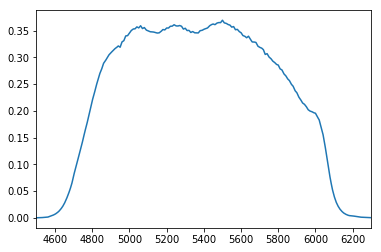

In [11]:
band = S.ObsBandpass('acs,wfc1,f555w') 
# This roughly approximates our bandpass
plt.plot(band.wave,band.throughput)
plt.xlim(4500,6300)

In [12]:
acenA_norm = acenA.renorm(0.01,'vegamag',band)
obsA = S.Observation(acenA_norm,band)

acenB_norm = acenB.renorm(1.33,'vegamag',band)
obsB = S.Observation(acenB_norm,band)

# Sets our magnitue to ~ actual mag of AcenA + AcenB

In [13]:
for obs in [obsA,obsB]:
    print("count over total area: {:.0f}".format(obs.countrate()))
#     print(obs.primary_area)
    print("count per cm2: {:.0f}".format(obs.countrate()/obs.primary_area))
    print()
    

count over total area: 1324500
count per cm2: 421601

count over total area: 392692
count per cm2: 124998



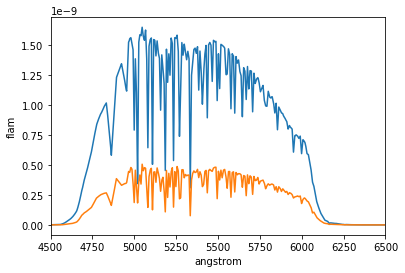

In [14]:
for obs in [obsA,obsB]:
    # Plot the spectra being seen at the camera
    plt.plot(obs.wave,obs.flux) # Angstrom, nm
    plt.xlim(4500,6500)
    plt.xlabel(obs.waveunits)
    plt.ylabel(obs.fluxunits)
    
# Doesnt change with a change in primary area? Units of y?

## Now we set out to pass this spectra through pyproper

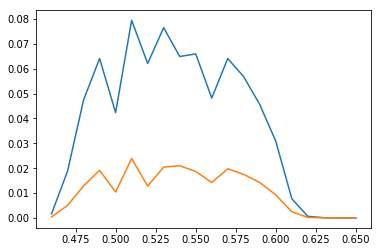

In [15]:
wavesA = obsA.wave
weightA = obsA.flux
wavelsA = []
weightsA = []

wavesB = obsB.wave
weightB = obsB.flux
wavelsB = []
weightsB = []

for i in range(0,len(wavesA)):
    if wavesA[i] > 4500 and wavesA[i] <= 6500:
        if wavesA[i]%100 == 0:
            wavelsA.append(wavesA[i]/10000)
            weightsA.append(weightA[i])
            
            wavelsB.append(wavesB[i]/10000)
            weightsB.append(weightB[i])
            
total = sum(weightsA) + sum(weightsB)
weightsA = [w/total for w in weightsA]
weightsB = [w/total for w in weightsB]

plt.plot(wavelsA,weightsA)
plt.plot(wavelsB,weightsB)

In [16]:
toliman_settings_2['tilt_x'] = 1. # Angular seperation of 1 arcsecond

source_A = {
            'wavelengths': wavelsA,
            'weights': weightsA, 
            'settings': toliman_settings_1
}

source_B = {
            'wavelengths': wavelsB,
            'weights': weightsB, 
            'settings': toliman_settings_2
}

sources = [source_A,source_B]

In [17]:
%%time
image = form_detector_image(prescription, sources, gridsize, detector_pitch, npixels)

Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/louis/anaconda3/l

KeyboardInterrupt: 

In [18]:
%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.show()

NameError: name 'image' is not defined

Process ForkPoolWorker-6:
Traceback (most recent call last):
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/louis/anaconda3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/Users/louis/.local/lib/python3.6/site-packages/PyPROPER3-1.0.0-py3.6-macosx-10.7-x86_64.egg/proper/prop_execute_multi.py", line 36, in prop_execute_multi
    psf, sampling = proper.prop_run(routine_name, lamda, gridsize, PASSVALUE = passvalue, QUIET = quiet, PHASE_OFFSET = phase_offset)
  File "/Users/louis/.local/lib/python3.6/site-packages/PyPROPER3-1.0.0-py3.6-macosx-10.7-x86_64.egg/proper/prop_run.py", line 137, in prop_ru

In [ ]:
beam_ratio = 0.4
gridsize = 2048

def binarized_ringed_600(r, phi):
    phase = 600.*1e-9*0.5 # Has units of pi
    return binarized_ringed_flipped(r, phi, phase)

tiny_tol = {
        'diam': 0.02, # 2cm diameter
        'm1_fl': 0.077, # 7.7cm focal length
        'beam_ratio': beam_ratio, # ????
        'tilt_x': 0.00,
        'tilt_y': 0.00,
        'opd_func': binarized_ringed_600,
        'use_caching':True
        }

detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

### Create our test star Mizar A

In [ ]:
# Metalicity taken as 0.015 ~ solar 
# log(g) calculated via Mass and Radius

MizarA  = S.Icat('phoenix',9000,0.015,4.02)
nwavels = 3501
wavels = np.linspace(3500,7000,nwavels)
specM = MizarA.sample(wavels)
print(MizarA.fluxunits)
print(MizarA.waveunits)

## odd behaviour seen past 4000 A

In [ ]:
plt.plot(wavels/10.,specM,label=r'Mizar A')
plt.xlabel(r'$\lambda$ (nm)')
# plt.plot(wavels/10, test_spec)
plt.ylabel('Flam')
plt.legend()
plt.title(r'Test Generating Spectra - Mizar A',y=1.01)

## Generate our filtered spectra and put them through proper

### Binary filters

In [ ]:
def custom_bandpass(wl, pass_range, value):
    """
    Outputs a scaled custom binary bandpass
    """
    bandpass = []
    for wave in wl:
        if wave >= pass_range[0] and wave <= pass_range[1]:
            bandpass.append(value)
        else:
            bandpass.append(0)
    return bandpass

In [ ]:
throughput_r = custom_bandpass(wavels, [5750,6500], 0.25)
throughput_g = custom_bandpass(wavels, [4750,5750], 0.5)
throughput_b = custom_bandpass(wavels, [4000,5000], 0.25)

plt.plot(wavels/10.,throughput_b,label=r'Mizar A blue',color='b')
plt.plot(wavels/10.,throughput_g,label=r'Mizar A green',color='g')
plt.plot(wavels/10.,throughput_r,label=r'Mizar A red',color='r')

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Throughput')
plt.legend()
plt.title("Binary filters throughput")

band_bin_b = S.ArrayBandpass(wavels, throughput_b, name='blue')
band_bin_g = S.ArrayBandpass(wavels, throughput_g, name='green')
band_bin_r = S.ArrayBandpass(wavels, throughput_r, name='red')

In [ ]:
# Sets our collecting area
r = 1 # cm
tinytol_area = np.pi*r**2
S.refs.setref(area=tinytol_area)  # cm2
S.showref()

In [ ]:
# Actual mag is 2.23
MizarA_bin_r = MizarA.renorm(2.23,'vegamag',band_bin_r)
MizarA_bin_g = MizarA.renorm(2.23,'vegamag',band_bin_g)
MizarA_bin_b = MizarA.renorm(2.23,'vegamag',band_bin_b)

##
test_band = S.ObsBandpass('acs,wfc1,f555w') 
test_MizarA = MizarA.renorm(2.23,'vegamag',test_band)
###


In [ ]:
total_pix = 2e6 # 8Mpix taken as 2Mpix due to fliters only allowing the relative amount though

obs_bin_r = S.Observation(MizarA_bin_r,band_bin_r,binset=wavels)
obs_bin_g = S.Observation(MizarA_bin_g,band_bin_g,binset=wavels)
obs_bin_b = S.Observation(MizarA_bin_b,band_bin_b,binset=wavels)

test_obs = S.Observation(test_MizarA,test_band)

for obs,filt,c in zip([obs_bin_b,obs_bin_g,obs_bin_r,test_obs],["BLUE","GREEN","RED","TEST"],['b','g','r','c']):
    obs.primary_area = tinytol_area
    print(filt + ":")
    
    total_rate = obs.countrate()
    rate_cm2 = obs.countrate()/obs.primary_area
    print("count over total area per second - {:.0f}".format(total_rate))
    print("count rate per cm2 per second - {:.0f}".format(rate_cm2))
    
    if filt == "GREEN":
        colour_rate = obs.countrate()
        pix_rate = obs.countrate()/total_pix
        
        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f}".format(filt,pix_rate))
        
    elif filt == "TEST":
        colour_rate = obs.countrate()
        pix_rate = obs.countrate()/npix
        
        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f}".format(filt,pix_rate))
        
    else:
        colour_rate = obs.countrate()
        pix_rate = obs.countrate()/npix

        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f} \n".format(filt,pix_rate))
        
        
#     print("count over all {} pixels per second - {:.0f}".format(filt,obs.countrate()))
#     print("counts per {} pixel per second - {:.4f} \n".format(filt,obs.countrate()/2e6))
#     print()
    
    # Plot the spectra being seen at the camera (with bayer filter applied)
#     obs.convert('counts')
    
    plt.plot(obs.wave,obs.flux,label=filt,color=c) # Angstrom
    plt.xlim(3800,7200)
    plt.title("Binary filter spectra, high res")
    plt.xlabel(obs.waveunits)
    plt.ylabel(obs.fluxunits)
    plt.legend()
    

In [ ]:
throughput_r = custom_bandpass(wavels, [5750,6500], 1)
throughput_g = custom_bandpass(wavels, [4750,5750], 1)
throughput_b = custom_bandpass(wavels, [4000,5000], 1)

plt.plot(wavels/10.,throughput_b,label=r'Mizar A blue',color='b')
plt.plot(wavels/10.,throughput_g,label=r'Mizar A green',color='g')
plt.plot(wavels/10.,throughput_r,label=r'Mizar A red',color='r')

plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Throughput')
plt.legend()
plt.title("Binary filters throughput")

band_bin_b = S.ArrayBandpass(wavels, throughput_b, name='blue')
band_bin_g = S.ArrayBandpass(wavels, throughput_g, name='green')
band_bin_r = S.ArrayBandpass(wavels, throughput_r, name='red')

In [ ]:
total_pix = 8e6 # 8Mpix

obs_bin_r = S.Observation(MizarA_bin_r,band_bin_r,binset=wavels)
obs_bin_g = S.Observation(MizarA_bin_g,band_bin_g,binset=wavels)
obs_bin_b = S.Observation(MizarA_bin_b,band_bin_b,binset=wavels)

test_obs = S.Observation(test_MizarA,test_band)

for obs,filt,c in zip([obs_bin_b,obs_bin_g,obs_bin_r,test_obs],["BLUE","GREEN","RED","TEST"],['b','g','r','c']):
    obs.primary_area = tinytol_area
    print(filt + ":")
    
    total_rate = obs.countrate()
    rate_cm2 = obs.countrate()/obs.primary_area
    print("count over total area per second - {:.0f}".format(total_rate))
    print("count rate per cm2 per second - {:.0f}".format(rate_cm2))
    
    if filt == "GREEN":
        colour_rate = obs.countrate()/2 # Half of all pixels are green
        npix = total_pix/2              # Half of all pixels are green
        pix_rate = obs.countrate()/npix
        
        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f}".format(filt,pix_rate))
        
    elif filt == "TEST":
        colour_rate = obs.countrate()
        npix = total_pix/4              # Take these pixels as 4 of our bayer pixels
        pix_rate = obs.countrate()/npix
        
        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f}".format(filt,pix_rate))
        
    else:
        colour_rate = obs.countrate()/4 # A quarter of all pixels are red/blue
        npix = total_pix/4              # A quarter of all pixels are red/blue
        pix_rate = obs.countrate()/npix

        print("count over all {} pixels per second - {:.0f}".format(filt,colour_rate))
        print("counts per {} pixel per second - {:.4f} \n".format(filt,pix_rate))
        
        
#     print("count over all {} pixels per second - {:.0f}".format(filt,obs.countrate()))
#     print("counts per {} pixel per second - {:.4f} \n".format(filt,obs.countrate()/2e6))
#     print()
    
    # Plot the spectra being seen at the camera (with bayer filter applied)
#     obs.convert('counts')
    
    plt.plot(obs.wave,obs.flux,label=filt,color=c) # Angstrom
    plt.xlim(3800,7200)
    plt.title("Binary filter spectra, high res")
    plt.xlabel(obs.waveunits)
    plt.ylabel(obs.fluxunits)
    plt.legend()
    

In [ ]:
spectra = []

for obs in [obs_bin_r,obs_bin_g,obs_bin_b]:
    waves = obs.wave
    weight = obs.flux
    wls = []
    weights = []

    for i in range(0,len(waves)):
        if waves[i] > 3500 and waves[i] <= 7200:
            if wavesA[i]%200 == 0: # Sample from every 200th wavelength
                wls.append(waves[i]/10000) # Convert to mirons for proper
                weights.append(weight[i])
    
    
    
    spectra.append((wls,weights))
    plt.plot(wls,weights)
    plt.title("Binary spectra filter, low res")
    plt.xlabel(obs.waveunits)
    plt.ylabel("microns")
    


In [ ]:
source_red = {
            'wavelengths': spectra[0][0],
            'weights': spectra[0][1], 
            'settings': toliman_settings_1
            }

source_green = {
            'wavelengths': spectra[1][0],
            'weights': spectra[1][1], 
            'settings': toliman_settings_1
            }

source_blue = {
            'wavelengths': spectra[2][0],
            'weights': spectra[2][1], 
            'settings': toliman_settings_1
            }

source_green = [source_green]
source_blue = [source_blue]
source_red = [source_red]

In [ ]:
%%time
image = form_detector_image(prescription, source_red, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Binary filter - red")
plt.show()


In [ ]:
%%time
image = form_detector_image(prescription, source_green, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Binary filter - green")
plt.show()

In [ ]:
%%time
image = form_detector_image(prescription, source_blue, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Binary filter - blue")
plt.show()

### Gaussian filters

In [ ]:
# Creating the custom bandpasses in pysynphot

throughput_r = []
throughput_g = []
throughput_b = []

for wave in wavels:
    throughput_r.append(np.exp(-pow((wave-6125),2)/(2*pow(200,2))))
    throughput_g.append(np.exp(-pow((wave-5250),2)/(2*pow(350,2))))
    throughput_b.append(np.exp(-pow((wave-4725),2)/(2*pow(250,2))))

plt.plot(wavels,throughput_b,label='blue')
plt.plot(wavels,throughput_r,label='red')
plt.plot(wavels,throughput_g,label='green')
plt.legend()
plt.title("Gaussian filters throughput")

band_gauss_b = S.ArrayBandpass(wavels, throughput_b, name='blue')
band_gauss_r = S.ArrayBandpass(wavels, throughput_r, name='red')
band_gauss_g = S.ArrayBandpass(wavels, throughput_g, name='green')

(green) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(blue) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(red) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(green) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
189454.54082058417
(blue) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
80677.49570615795
(red) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
40045.427283738216


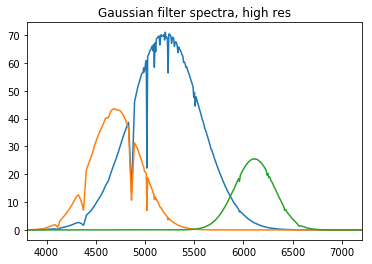

In [477]:
MizarA_gauss_g = MizarA.renorm(2.23,'vegamag',band_gauss_g)
MizarA_gauss_b = MizarA.renorm(2.23,'vegamag',band_gauss_b)
MizarA_gauss_r = MizarA.renorm(2.23,'vegamag',band_gauss_r)

obs_gauss_g = S.Observation(MizarA_gauss_g,band_gauss_g)
obs_gauss_b = S.Observation(MizarA_gauss_b,band_gauss_b)
obs_gauss_r = S.Observation(MizarA_gauss_r,band_gauss_r)

for obs in [obs_gauss_g,obs_gauss_b,obs_gauss_r]:
    obs.primary_area = np.pi*pow(1,2) # aperture radius of 1cm (tinytol)
    obs.initbinset()
    obs.initbinflux()
    print(obs.countrate(binned=False)) # Photon count rate (per second?)

    # Plot the spectra being seen at the camera (with bayer filter applied)
    plt.plot(obs.wave,obs.flux) # Angstrom, nm
    plt.xlim(3800,7200)
    plt.title("Gaussian filter spectra, high res")

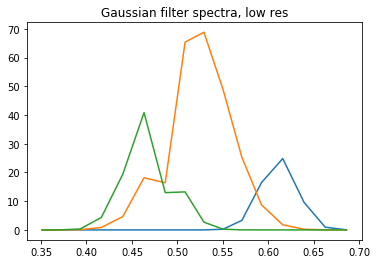

In [478]:
spectra = []

for obs in [obs_gauss_r,obs_gauss_g,obs_gauss_b]:
    waves = obs.wave
    weight = obs.flux
    wls = []
    weights = []

    for i in range(0,len(waves)):
        if waves[i] > 3500 and waves[i] <= 7200:
            if wavesA[i]%200 == 0:
                wls.append(waves[i]/10000)
                weights.append(weight[i])
                
    spectra.append((wls,weights))
    plt.plot(wls,weights)
    plt.title("Gaussian filter spectra, low res")

In [479]:
source_red = {
            'wavelengths': spectra[0][0],
            'weights': spectra[0][1], 
            'settings': toliman_settings_1
            }

source_green = {
            'wavelengths': spectra[1][0],
            'weights': spectra[1][1], 
            'settings': toliman_settings_1
            }

source_blue = {
            'wavelengths': spectra[2][0],
            'weights': spectra[2][1], 
            'settings': toliman_settings_1
            }

source_green = [source_green]
source_blue = [source_blue]
source_red = [source_red]

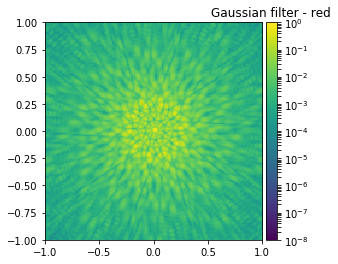

CPU times: user 12.3 s, sys: 10.2 s, total: 22.5 s
Wall time: 1min 42s


In [480]:
%%time
image = form_detector_image(prescription, source_red, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Gaussian filter - red")
plt.show()

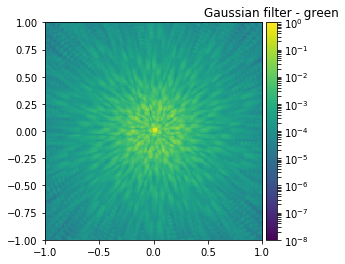

CPU times: user 11.9 s, sys: 11.3 s, total: 23.2 s
Wall time: 46.6 s


In [481]:
%%time
image = form_detector_image(prescription, source_green, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Gaussian filter - green")
plt.show()

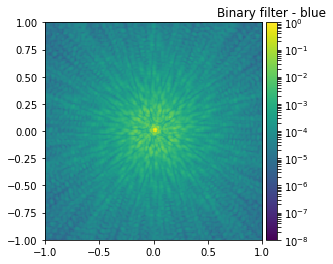

CPU times: user 11.9 s, sys: 10.4 s, total: 22.3 s
Wall time: 48.8 s


In [482]:
%%time
image = form_detector_image(prescription, source_blue, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("Binary filter - blue")
plt.show()

### HST filters

Text(0.5,1,'HST filters throughput')

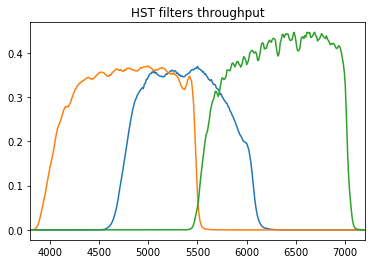

In [483]:
band_HST_g = S.ObsBandpass('acs,wfc1,f555w') 
band_HST_b = S.ObsBandpass('acs,wfc1,f475w')
band_HST_r = S.ObsBandpass('acs,wfc1,f625w')
# This roughly approximates our bandpass - Load in images of actual camera observations later

plt.plot(band_HST_g.wave,band_HST_g.throughput)
plt.plot(band_HST_b.wave,band_HST_b.throughput)
plt.plot(band_HST_r.wave,band_HST_r.throughput)
plt.xlim(3800,7200)
plt.title("HST filters throughput")


171416.193394875
255983.24979160214
174858.5107409873


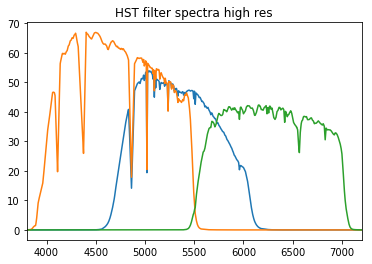

In [484]:
MizarA_HST_g = MizarA.renorm(2.23,'vegamag',band_HST_g)
MizarA_HST_b = MizarA.renorm(2.23,'vegamag',band_HST_b)
MizarA_HST_r = MizarA.renorm(2.23,'vegamag',band_HST_r)

obs_HST_g = S.Observation(MizarA_HST_g,band_HST_g)
obs_HST_b = S.Observation(MizarA_HST_b,band_HST_b)
obs_HST_r = S.Observation(MizarA_HST_r,band_HST_r)


for obs in [obs_HST_g,obs_HST_b,obs_HST_r]:
    obs.primary_area = np.pi*pow(1,2) # aperture radius of 1cm (tinytol)
    obs.initbinset()
    obs.initbinflux()
    print(obs.countrate(binned=False)) # Photon count rate (per second?)

    # Plot the spectra being seen at the camera (with bayer filter applied)
    plt.plot(obs.wave,obs.flux) # Angstrom, nm
    plt.xlim(3800,7200)
    plt.title("HST filter spectra high res")

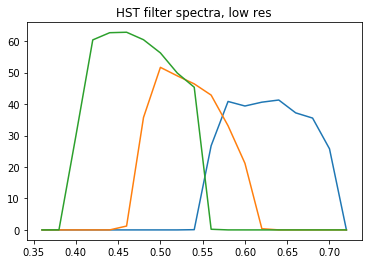

In [485]:
spectra = []

for obs in [obs_HST_r,obs_HST_g,obs_HST_b]:
    waves = obs.wave
    weight = obs.flux
    wls = []
    weights = []

    for i in range(0,len(waves)):
        if waves[i] > 3500 and waves[i] <= 7200:
            if wavesA[i]%200 == 0:
                wls.append(waves[i]/10000)
                weights.append(weight[i])
                
    spectra.append((wls,weights))
    plt.plot(wls,weights)
    plt.title("HST filter spectra, low res")

In [495]:
source_red = {
            'wavelengths': spectra_custom[0][0],
            'weights': spectra_custom[0][1], 
            'settings': toliman_settings_1
            }

source_green = {
            'wavelengths': spectra_custom[1][0],
            'weights': spectra_custom[1][1], 
            'settings': toliman_settings_1
            }

source_blue = {
            'wavelengths': spectra_custom[2][0],
            'weights': spectra_custom[2][1], 
            'settings': toliman_settings_1
            }

source_red = [source_red]
source_green = [source_green]
source_blue = [source_blue]

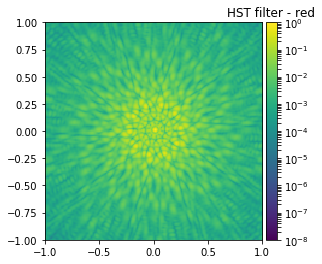

CPU times: user 11.8 s, sys: 12 s, total: 23.8 s
Wall time: 48.5 s


In [496]:
%%time
image = form_detector_image(prescription, source_red, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("HST filter - red")
plt.show()

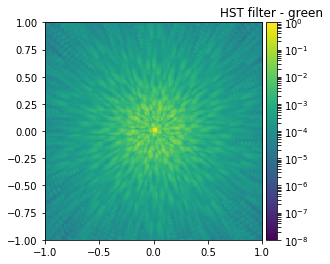

CPU times: user 12.6 s, sys: 8.83 s, total: 21.4 s
Wall time: 1min 6s


In [488]:
%%time
image = form_detector_image(prescription, source_green, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("HST filter - green")
plt.show()

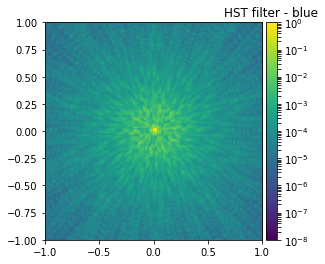

CPU times: user 12.2 s, sys: 14.4 s, total: 26.6 s
Wall time: 47.2 s


In [489]:
%%time
image = form_detector_image(prescription, source_blue, gridsize, detector_pitch, npixels)

%matplotlib inline
view_psf(image/image.max(axis=None), detector_pitch/1e-3, 1., vmin=1e-8)
plt.title("HST filter - blue")
plt.show()

In [170]:
S.showref()

   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True
      area: 3.141592653589793
thermtable: /Users/louis/special_project/pysynphot/grp/hst/cdbs/mtab/tae17277m_tmt.fits
graphtable: /Users/louis/special_project/pysynphot/grp/hst/cdbs/mtab/2381905mm_tmg.fits
 comptable: /Users/louis/special_project/pysynphot/grp/hst/cdbs/mtab/24u1536nm_tmc.fits
